Background: I used to work for PLDT, a telecommunications company. When it acquired another telecommunications company, Sun Cellular, we suddenly had a lot of facilities to take into consideration. I needed to analyze the effectiveness and coverage of all our BTS (Base Transmitter Station). The analysis should be on a granular level since this will be presented to all PLDT districts in the whole country to be used by their sales and engineering teams. A "Barangay" in the Philippines is similar to a District in the USA. Both are larger than a household but smaller than a city.

I worked with 2 data sets; BTS data, which is the company data and Barangays data, which is available from the government website.

In [15]:
import pandas as pd
import numpy as np
from math import *
from geopy.distance import *
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


In [16]:
#BTS data
BTS = pd.read_csv("BTS.csv")
print("Num of BTS: ", BTS.shape[0])
BTS["Index"] = BTS["BTS"]
BTS = BTS.set_index("Index")
print(BTS[0:5])

Num of BTS:  7133
        BTS   Latitude   Longitude  Radius
Index                                     
A37     A37   8.971306  125.392364     1.5
R69     R69   9.341972  125.514969     1.5
4418   4418   8.671445  125.661781     1.5
R77     R77   8.386945  125.999557     1.5
584     584  14.650139  120.358948     1.5


In [17]:
#Barangay data
Barangay = pd.read_csv("Barangays.csv")
cols = ['NSCB', 'Brgy', 'City', 'Region', 'Province', 'District', 'Latitude',
       'Longitude', 'Radius']
Barangay = Barangay[cols]
Barangay["NSCB"] = Barangay["NSCB"].astype(str)
Barangay["Index"] = Barangay["NSCB"]
Barangay = Barangay.set_index("Index")
print("Num of Barangays: ", Barangay.shape[0])
print(Barangay.head(5))

Num of Barangays:  41994
                NSCB            Brgy                 City Region Province  \
Index                                                                       
137401001  137401001  Addition Hills  CITY OF MANDALUYONG    NCR      NCR   
137401002  137401002   Bagong Silang  CITY OF MANDALUYONG    NCR      NCR   
137401003  137401003  Barangka Drive  CITY OF MANDALUYONG    NCR      NCR   
137401004  137401004  Barangka Ibaba  CITY OF MANDALUYONG    NCR      NCR   
137401005  137401005  Barangka Ilaya  CITY OF MANDALUYONG    NCR      NCR   

           District   Latitude   Longitude  Radius  
Index                                               
137401001  GMM EAST  14.586765  121.037094    0.62  
137401002  GMM EAST  14.592816  121.028816    0.21  
137401003  GMM EAST  14.573491  121.035763    0.27  
137401004  GMM EAST  14.571926  121.037182    0.21  
137401005  GMM EAST  14.573021  121.045574    0.37  


Info on BTS data:

    Radius - shows the radius of coverage of a BTS in kilometers. Data coverage for all company BTS is approximated at 1.5 kilometers
    BTS - the name of the BTS. (names have been changed for privacy)
    Latitude - latitude of BTS in decimal degrees
    Longitude - longitude of BTS in decimal degrees
    
Info on the Barangays data:

    NSCB - unique code used by the government to identify each Barangay
    Brgy - name of the Barangay
    Latitude - latitude of Barangay in decimal degrees
    Longitude - longitude of Barangay in decimal degrees
    Radius - approximates a Barangay to be a circle with radius denoted in kilometers
    
Important Notes:
The coverage of a BTS is not strictly 1.5 kilometers. It is dependent on other factors, such as; altitude, the number of tall buildings, etc.
The government data approximates a Barangay in the shape of a circle. This works better for simplicity. However, it is important to take note of this when looking at the results of the analysis.
    

In [18]:
def area_intersect (d, r1, r2):
    a_c1 = pi*(pow(r1,2))
    a_c2 = pi*(pow(r2,2)) 
    if d >= (r1+r2):
        return None
    elif d < (r1+r2):
        if d <= abs(r1-r2):
            if r1 < r2:
                return a_c1
            elif r2 < r1:
                return a_c2
        elif d > abs(r1-r2): 
            a1 = (pow(r1,2)-pow(r2,2)+pow(d,2))/(2*d)
            a2 = (pow(r2,2)-pow(r1,2)+pow(d,2))/(2*d)
            b = sqrt(pow(r1,2)-pow(a1,2))
            tht1 = 2*(acos(a1/r1))
            tht2 = 2*(acos(a2/r2))
            sc_1 = (tht1/(2*pi))*(a_c1)
            sc_2 = (tht2/(2*pi))*(a_c2)
            t_1 = a1*b
            t_2 = a2*b
            sg_1 = sc_1 - t_1
            sg_2 = sc_2 - t_2
            return sg_1 + sg_2         
    else:
        return None    

In [66]:
#input name, dataframe where input comes from, dataframe to find coverage in
def area_covered (inp_name, df1, df2):
    x = pd.DataFrame(columns = [df2.columns[0], "Percent Covered", "Radius", "Area of Intersect", "Latitude", "Longitude"])
    name_lat = df1.loc[inp_name]["Latitude"]
    name_long = df1.loc[inp_name]["Longitude"]
    name_radius = df1.loc[inp_name]["Radius"]
    i = 1
    for index, row in df2.iterrows():
        d = great_circle((name_lat,name_long),(row.loc["Latitude"],row.loc["Longitude"])).kilometers
        z = area_intersect(d,name_radius,row.loc["Radius"])
        if z is not None:
            x.loc[i] = [str(index), z/(pi* pow(row.loc["Radius"],2)), row.loc["Radius"], z,row.loc["Latitude"] , row.loc["Longitude"]]
            i += 1    
    return x

In [81]:
def show_area_covered (inp_name, df1, df2):
    name_lat = df1.loc[inp_name]["Latitude"]
    name_long = df1.loc[inp_name]["Longitude"]
    name_radius = df1.loc[inp_name]["Radius"]
    g = area_covered(inp_name, df1, df2)
    
    %matplotlib inline
    plt.figure(figsize=(5,5))
    m = Basemap(width=12000,height=10000,projection='tmerc', resolution='c',lat_0=name_lat,lon_0=name_long)
    m.scatter(name_long,name_lat, latlon=True, s = 100)
       
    Longitudes = g["Longitude"].tolist()
    Latitudes = g["Latitude"].tolist()
    m.scatter(Longitudes, Latitudes, latlon=True)
    
    for index, row in g.iterrows():
        if (abs(row["Latitude"] - name_lat) < 180) and (abs(row["Longitude"] - name_long) < 180):
            m.drawgreatcircle(name_long,name_lat,row["Longitude"],row["Latitude"])
            row_long,row_lat = m(row.loc["Longitude"], row.loc["Latitude"])
            #m.plot(row_long, row_lat, c="red")
        else:
            return None
    
    print("Areas covered by", inp_name)
    print ("\n")
    print(g)


Areas covered by A37


         NSCB  Percent Covered  Radius  Area of Intersect  Latitude  \
1   160201002         0.101658    1.31           0.548067  8.950885   
2   160201014         0.691224    0.30           0.195439  8.962605   
3   160201016         0.988098    0.34           0.358846  8.965730   
4   160201017         1.000000    0.35           0.384845  8.969800   
5   160201018         0.222163    0.50           0.174487  8.971260   
6   160201019         0.773120    0.29           0.204264  8.975855   
7   160201021         0.102200    0.49           0.077089  8.979120   
8   160201024         1.000000    0.71           1.583677  8.975545   
9   160209004         0.207676    1.37           1.224550  8.968880   
10  160209006         0.956126    0.91           2.487411  8.968845   

     Longitude  
1   125.388725  
2   125.401562  
3   125.401535  
4   125.401756  
5   125.407883  
6   125.403889  
7   125.406929  
8   125.395851  
9   125.374287  
10  125.386360  


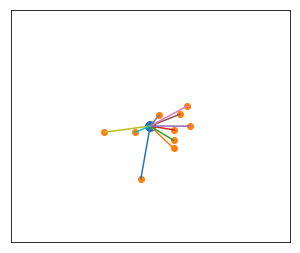

In [82]:
show_area_covered("A37", BTS, Barangay)

Areas covered by 160201019


     BTS  Percent Covered  Radius  Area of Intersect  Latitude   Longitude
1    A37         0.028898     1.5           0.204264  8.971306  125.392364
2   4516         0.037378     1.5           0.264208  8.976141  125.412249
3  M2232         0.037378     1.5           0.264208  8.974040  125.408900


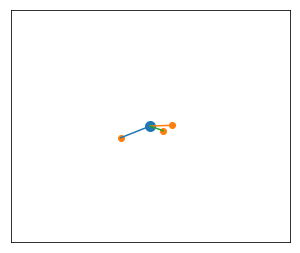

In [84]:
show_area_covered("160201019", Barangay, BTS)